# Homework 6 - Deep Learning

Усложните модель UNET с семинара, обучите ее на датасете `OXFORD-PETS`, добейтесь попиксельной Accuracy в 88%. Для этого вам понадобится добавить в нее еще блоков вниз и блоков вверх, а также возможно увеличить `base_channels`.

Используйте следующий трансформ для изображений:

```python
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)
```

Сдайте свои предсказания для тестовой выборки этого датасета (`split='test'`). Сделайте предсказания для следующих объектов:

```python
np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)
```


Загрузите свои предсказания в чекер, воспользуйтесь функциями `torch.save`, ваш тензор с предсказаниями должен иметь размер `[200, 1, 256, 256]`.

> #### NB
> **Не забудьте перевести перед сохранением предсказания в torch.uint8, так они занимают гораздо меньше места!**

## Импорт библиотек

In [1]:
import warnings

import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.models import alexnet, vgg11, googlenet, resnet18
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from typing import List, Tuple

# import importlib
# task5 = importlib.import_module("5 - Architects")
# task4 = importlib.import_module("4 - RegularizeConvNet")
# task3 = importlib.import_module("3 - ConvNets")
# task2 = importlib.import_module("2 - NeuralOptim")

%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

plt.rc('font', size=20)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

## Импорт датасета

In [2]:
from torchvision.datasets import OxfordIIITPet

In [3]:
# на некотором железе невозможно подставить лямбда-функции в T.Lambda()
# подробнее тут:
# https: // discuss.pytorch.org/t/cant-pickle-local-object-dataloader-init-locals-lambda/31857

def temp_lambda(x):
    return (x-1).long()


In [4]:
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

# этот метод тоже не помог

# target_transform = T.Compose(
#     [
#         T.Resize((256, 256)),
#         T.PILToTensor(),
#         T.Lambda(temp_lambda)
#     ]
# )


# THIS TRANSFORM WOULD NOT WORK IN SOME CASES

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        # T.Lambda(lambda x: (x - 1).long())
    ]
)


train_dataset = OxfordIIITPet("../../datasets/oxpfordpet",
                              transform=transform,
                              target_transform=target_transform,
                              target_types='segmentation',
                              download=True
                              )
valid_dataset = OxfordIIITPet("../../datasets/oxfordpet",
                              transform=transform,
                              split='test',
                              target_transform=target_transform,
                              target_types='segmentation',
                              download=True
                              )


In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=32, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=32, pin_memory=True)

## Соберем служебные функции

In [6]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, loss_fn):
    model.to_device()
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        # instead of Lambda
        y = (y - 1).long()

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1)) # to count loss properly we need to make it 1D

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy


In [7]:
@torch.inference_mode()
def evaluate(model, loader, loss_fn) -> Tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        # instead of Lambda
        y = (y - 1).long()

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy


In [8]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device)
    model.eval()
    predictions = []
    for x, y in tqdm(loader, desc='Prediction'):
        # instead of Lambda
        y = (y - 1).long()
        
        x, y = x.to(device), y.to(device)
        output = model(x)
        predictions.append(torch.argmax(output, axis=1))
    return torch.concat(predictions)


In [9]:
from IPython.display import clear_output


def plot_stats(
    train_loss: List[float],
    valid_loss: List[float],
    train_accuracy: List[float],
    valid_accuracy: List[float],
    title: str,
    lr=None
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

    if lr:
        plt.figure(figsize=(16, 8))

        plt.title(title + ' Learning Rate')
        plt.plot(lr, label='Learning Rate')
        plt.grid()

        plt.show()


In [20]:
@torch.inference_mode()
def visualize(model, batch):
    model.to(device)
    model.eval()

    xs, ys = batch
    
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).to(device)).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

## Пишем модель

В исходном примере размер изображения был 128х128

Для того, чтобы было возможно сделать большее количество слоев вверх и вниз, сделаем исходный размер 256х256

In [11]:
def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 16

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        # Это - новые слои
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)
        # Это - новые слои
        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 2)
        self.up4 = conv_plus_conv(base_channels * 16, base_channels * 4)

        self.bottleneck = conv_plus_conv(base_channels * 8, base_channels * 8)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # В нашем случае N = 256
        # x.shape = (N, N, 3)

        residual1 = self.down1(x)  # x.shape: (N, N, 3) -> (N, N, base_channels) (256, 256, 3) -> (256, 256, 16)
        x = self.downsample(residual1)  # x.shape: (N, N, base_channels) -> (N // 2, N // 2, base_channels) (256, 256, 16) -> (128, 128, 16)

        residual2 = self.down2(x)  # x.shape: (N // 2, N // 2, base_channels) -> (N // 2, N // 2, base_channels * 2) (128, 128, 16) -> (128, 128, 32)
        x = self.downsample(residual2)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 4, N // 4, base_channels * 2) (128, 128, 32) -> (64, 64, 32)

        residual3 = self.down3(x) # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 4, N // 4, base_channels * 4) (64, 64, 32) -> (64, 64, 64)
        x = self.downsample(residual3) # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 8, N // 8, base_channels * 4) (64, 64, 64) -> (32, 32, 64)

        residual4 = self.down4(x) # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 8, N // 8, base_channels * 8) (32, 32, 64) -> (32, 32, 128)
        x = self.downsample(residual4) # x.shape: (N // 8, N // 8, base_channels * 8) -> (N // 16, N // 16, base_channels * 8) (32, 32, 128) -> (16, 16, 128)

        # LATENT SPACE DIMENSION DIM = N // 16
        # SOME MANIPULATION MAYBE
        x = self.bottleneck(x)  # x.shape: (N // 16, N // 16, base_channels * 8) -> (N // 16, N // 16, base_channels * 8)
        # SOME MANIPULATION MAYBE
        # LATENT SPACE DIMENSION DIM = N // 16

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 16, N // 16, base_channels * 8) -> (N // 8, N // 8, base_channels * 8)
        x = torch.cat((x, residual4), dim=1)  # x.shape: (N // 8, N // 8, base_channels * 8) -> (N // 8, N // 8, base_channels * 16)
        x = self.up4(x)  # x.shape: (N // 8, N // 8, base_channels * 16) -> (N // 8, N // 8, base_channels * 4)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 4, N // 4, base_channels * 4)
        x = torch.cat((x, residual3), dim=1)  # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 4, N // 4, base_channels * 8)
        x = self.up3(x)  # x.shape: (N // 4, N // 4, base_channels * 8) -> (N // 4, N // 4, base_channels * 2)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 2, N // 2, base_channels * 2)
        x = torch.cat((x, residual2), dim=1)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 2, N // 2, base_channels * 4)
        x = self.up2(x)  # x.shape: (N // 2, N // 2, base_channels * 4) -> (N // 2, N // 2, base_channels)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, base_channels) -> (N, N, base_channels)
        x = torch.cat((x, residual1), dim=1)  # x.shape: (N, N, base_channels) -> (N, N, base_channels * 2)
        x = self.up1(x)  # x.shape: (N, N, base_channels * 2) -> (N, N, base_channels)

        x = self.out(x)  # x.shape: (N, N, base_channels) -> (N, N, 3)

        return x


In [12]:
# Создаем модель
model = UNET()

# Зададим функцию ошибки и оптимизатор
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)


In [13]:
oc_scheduler = OneCycleLR(optimizer=optimizer, max_lr=0.01,
                          epochs=30, steps_per_epoch=len(train_loader))


In [14]:
def train_w_scheduler(model: nn.Module, 
                      data_loader: DataLoader, 
                      optimizer: torch.optim.Optimizer,
                      oc_scheduler,
                      loss_fn):
    model.to(device)
    model.train()

    train_loss = 0
    total = 0
    correct = 0
    lrs = []

    for x, y in tqdm(data_loader, desc='Train'):
        bs = y.size(0)

        # instead of Lambda
        y = (y - 1).long()

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1)) # to count loss properly we need to make it 1D

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

        oc_scheduler.step()  # adding scheduler in batch cycle
        lrs.append(optimizer.param_groups[0]['lr'])

    train_loss /= len(data_loader)
    accuracy = correct / total

    return train_loss, accuracy, lrs


In [15]:
def whole_train_valid_cycle_with_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    lr_history = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy, lrs = train_w_scheduler(model, 
                                                                   train_loader,
                                                                   optimizer,
                                                                   oc_scheduler,
                                                                   loss_fn)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)
        lr_history.append(lrs)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title,
            lr=lr_history
        )

        visualize(model, next(iter(valid_loader)))

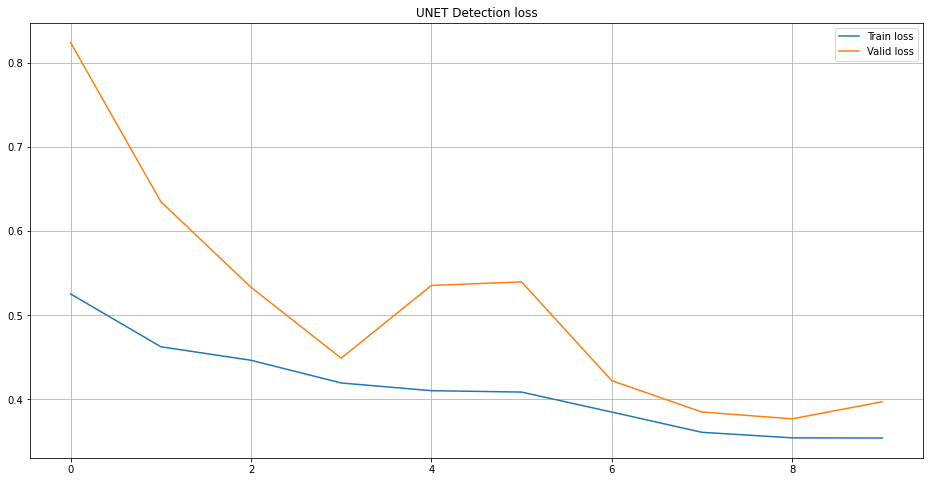

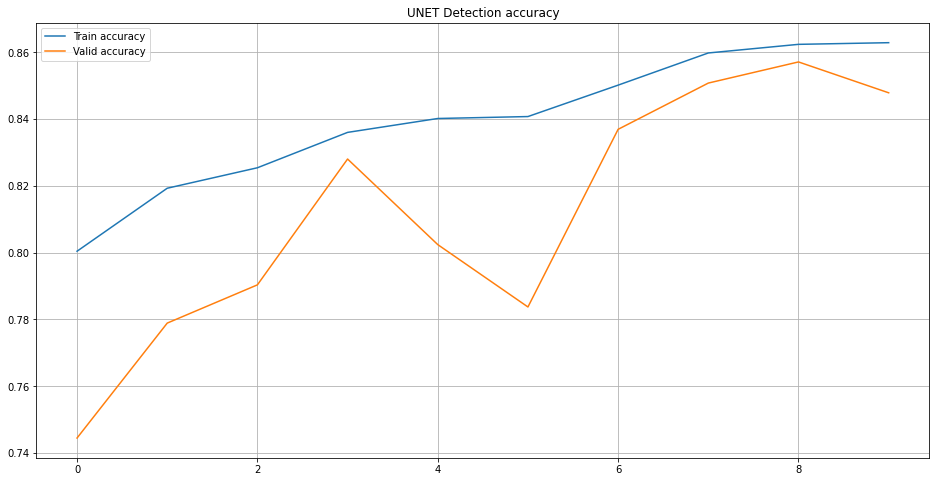

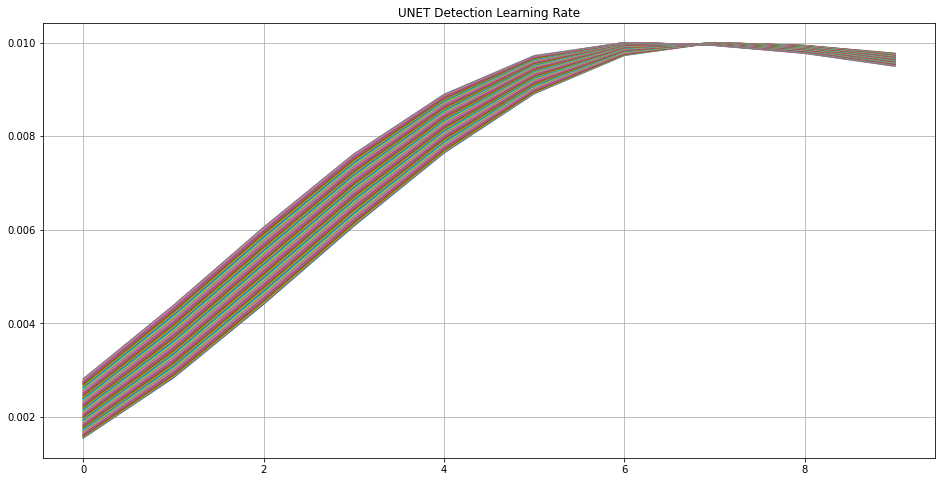

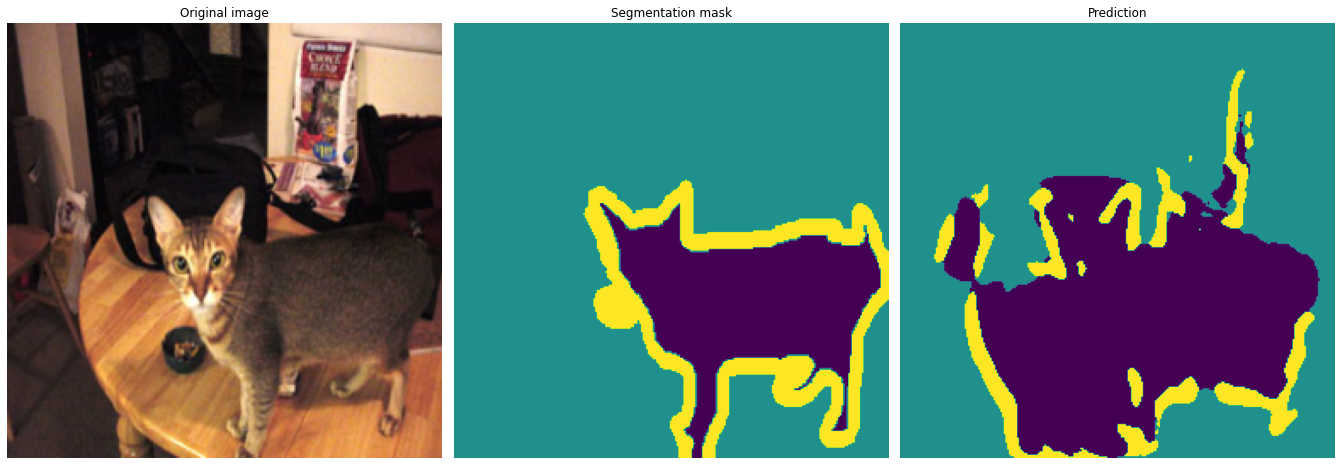

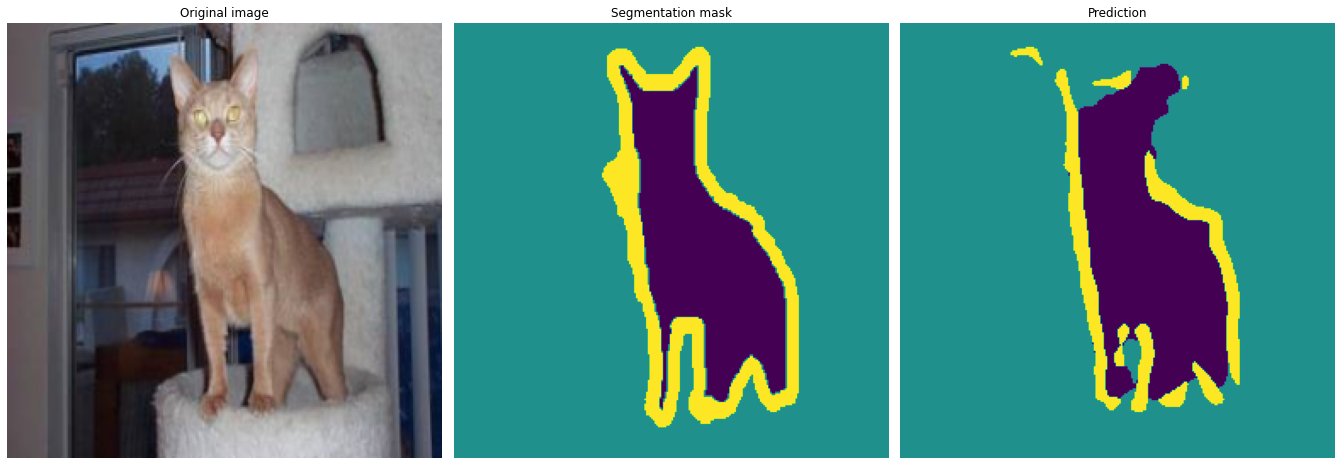

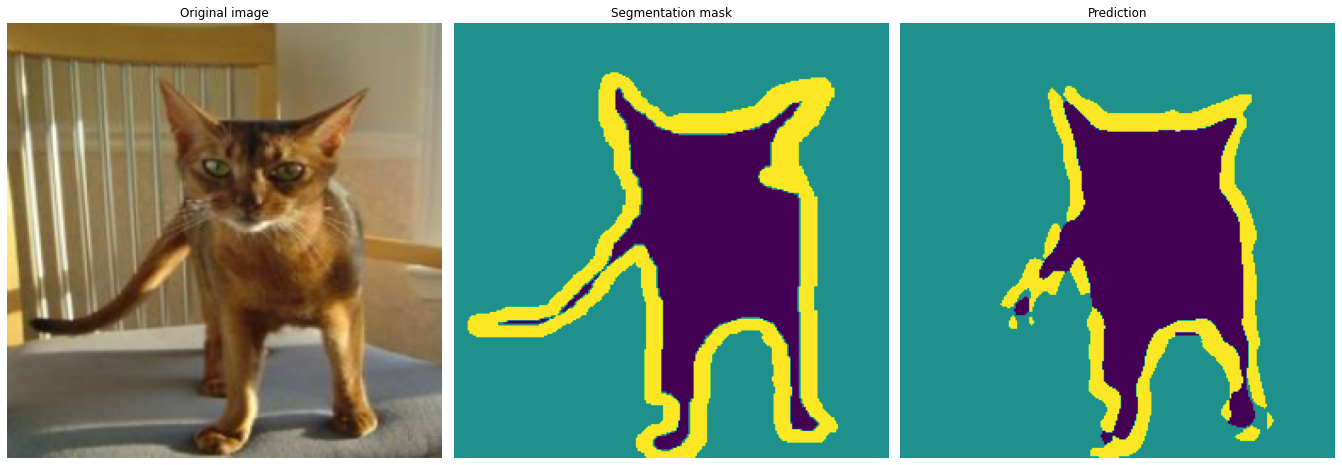

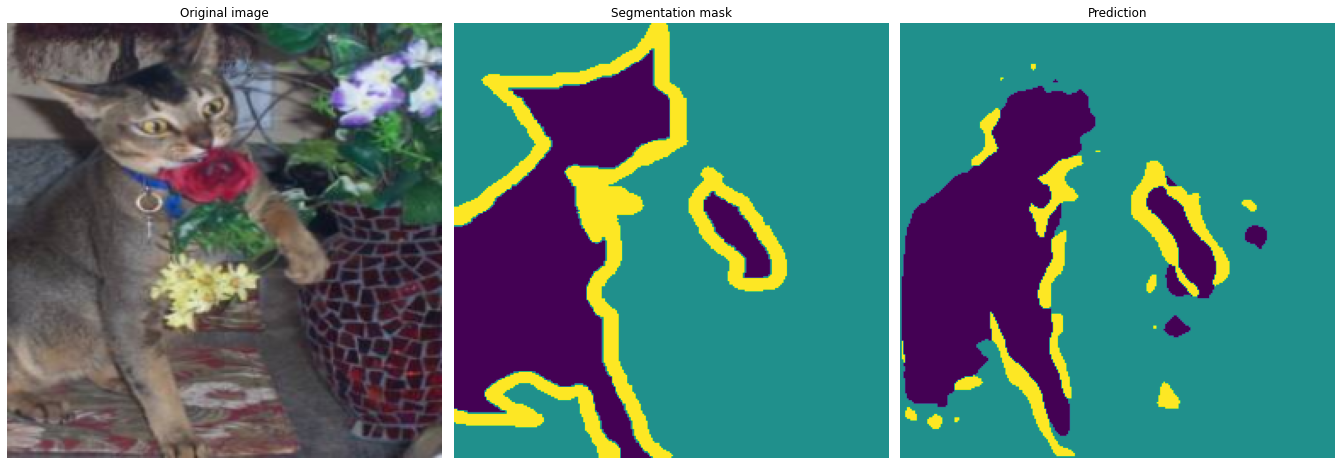

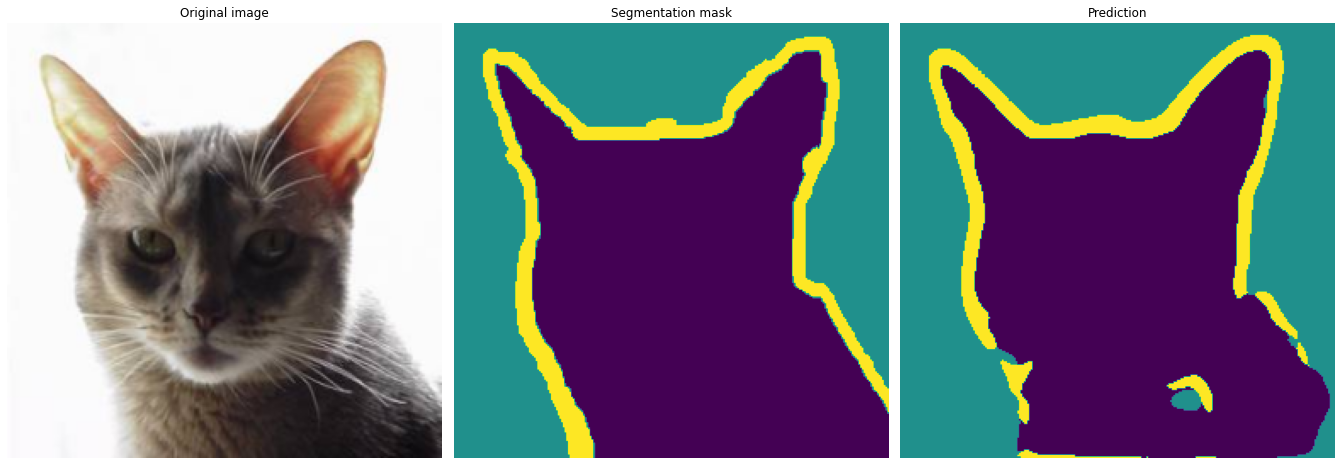

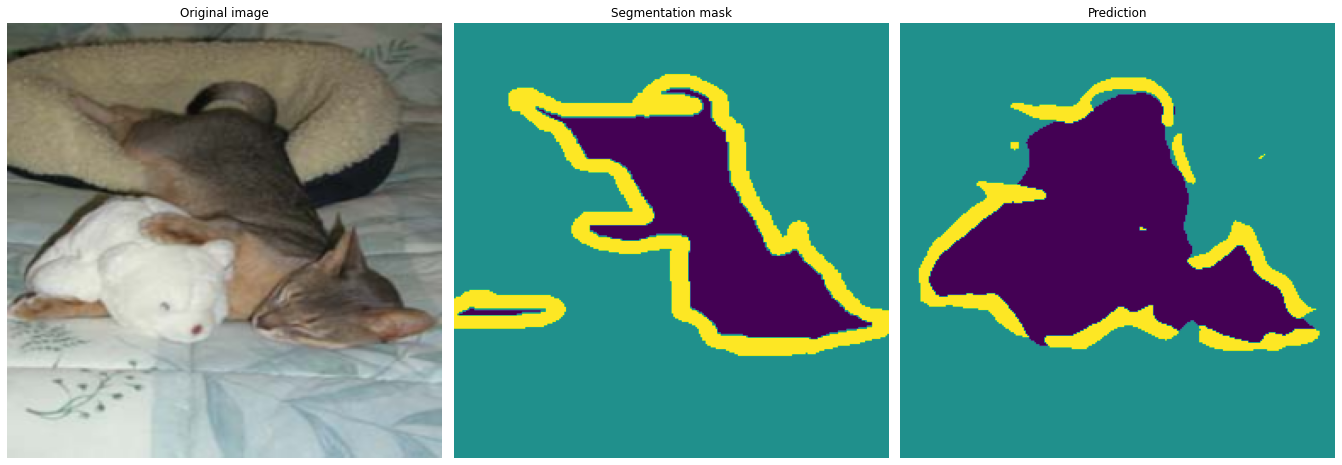

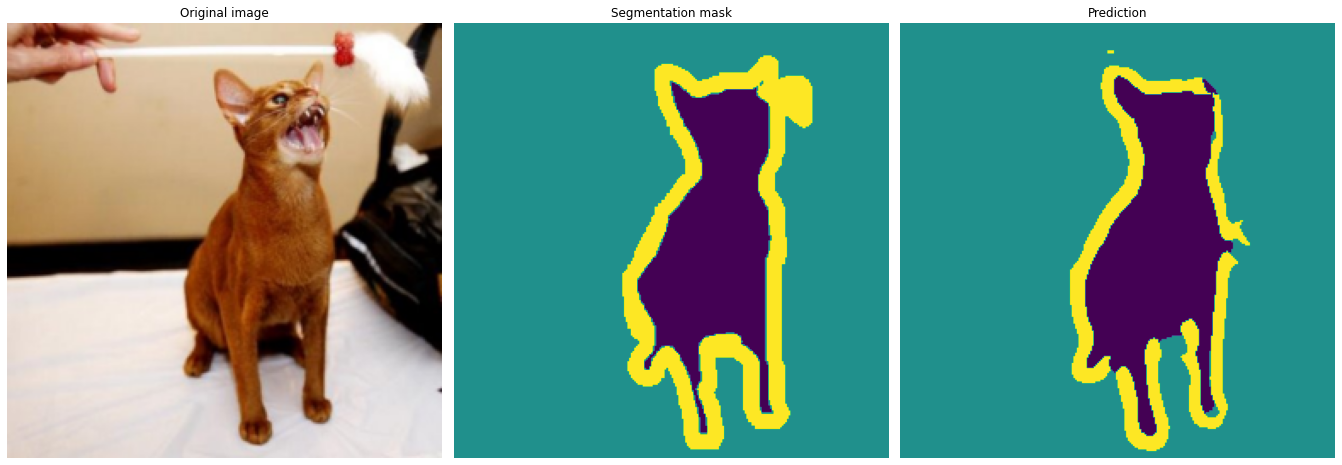

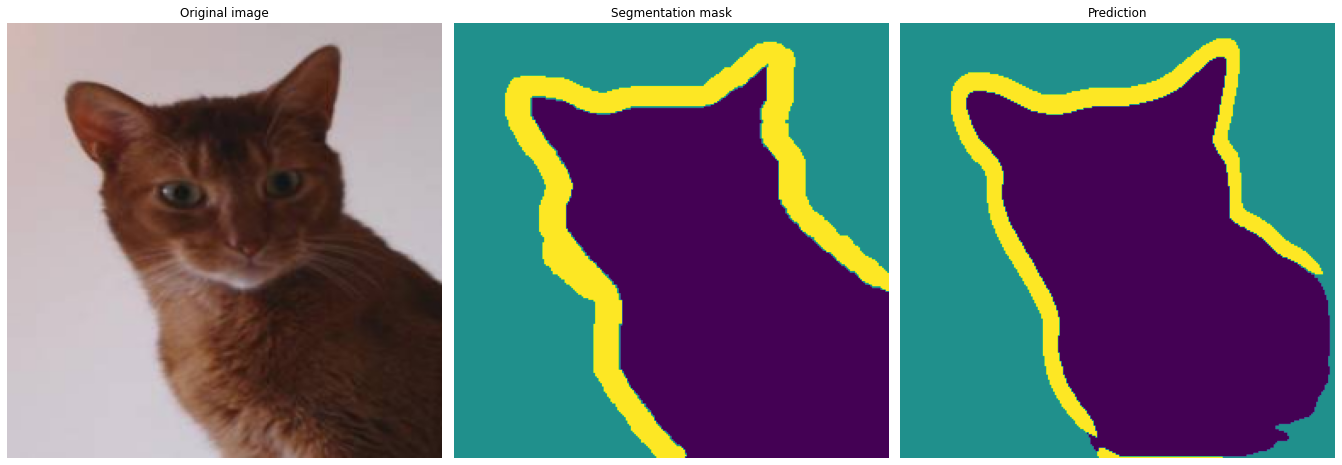

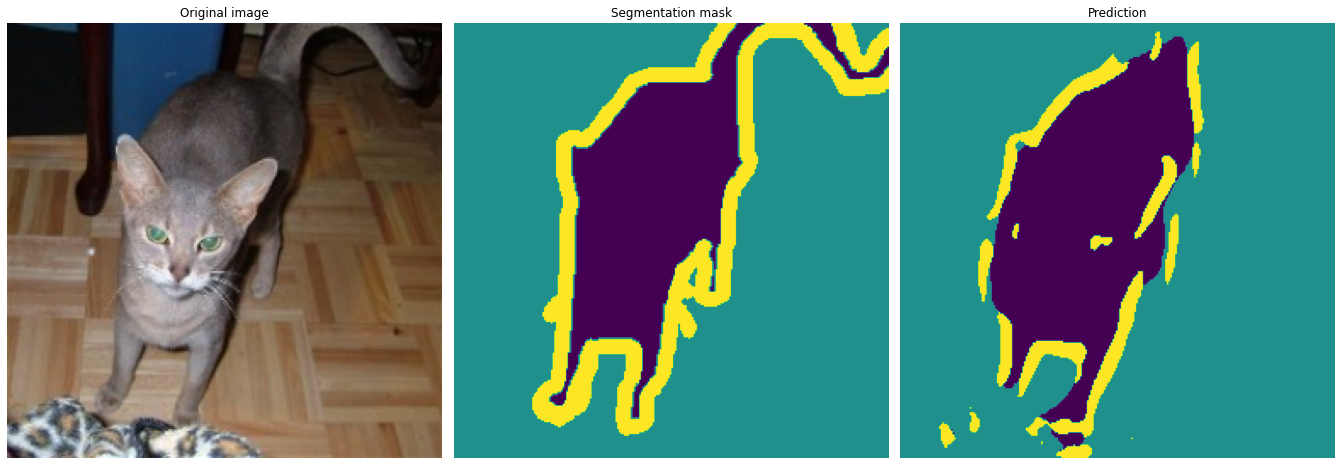

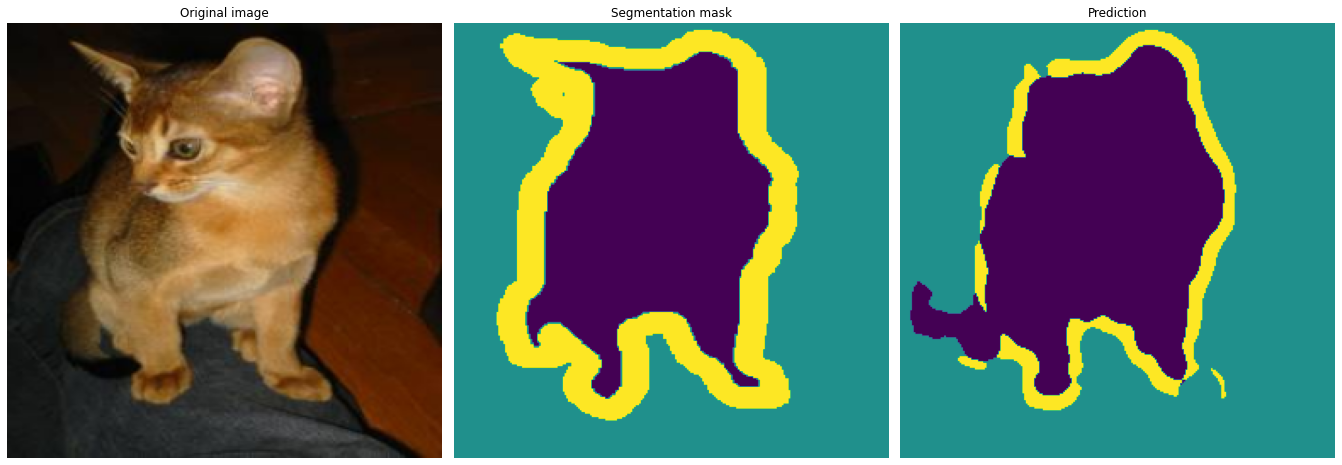

Train:  45%|████▍     | 26/58 [06:03<06:18, 11.81s/it] 

In [21]:
whole_train_valid_cycle_with_scheduler(model, 30, 'UNET Detection')


## Записываем предсказания

np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)

In [ ]:
from torch.utils.data import Subset

test_dataset = Subset(valid_dataset, idx)

test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, num_workers=32, pin_memory=True)


In [ ]:
preds = predict(model, test_loader, device).to(torch.uint8).unsqueeze(dim=1)
preds.shape


In [ ]:
# сохраним предсказания на диск
torch.save(preds, 'unet_6.pkl')
